torch for general tensor operations and torch.nn for constructing the architecture of your model.

In [1]:
import torch
import torch.nn as nn #for building neural networks

## Attention Block

heads is the number of parts the embedding is split into

component of nn : Module Class (nn.Module)

 The base class for all neural network modules, allowing you to create custom models.

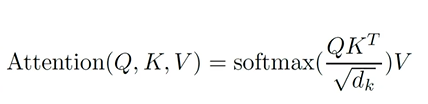

In [17]:
class SelfAttention(nn.Module):  #inherits from `nn.Module`
#     INITIALIZATION
    def __init__(self, embed_size, heads):
#        super Calls the constructor of the parent class (nn.Module).
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
#         ensure that heads is a multiple of embed_size
        assert (self.head_dim * heads == embed_size), "embed size needs to be divisible by heads"
        
# These three linear layers are used to transform the input embeddings into value, key, and query vectors
        self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
#         heads * self.head_dim = embed_size, so all the heads are concatenated
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
    
    def forward(self, values , keys, query, mask):
#         N = no. of examples sent at the same time (batch size)
        N = query.shape[0]
#     This depends on the source sentence and target sentence length i.e where we are using it like in encoder decoder 
        val_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
    
#     split embedding into self.head pieces
#     initially values was (N, value_len, embed_size)  
        values = values.reshape(N, val_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim) 
        
#         after reshape send them thr a linear layer
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)
#     multiply the query with keys. [queries, keys] means sending the keys and queries
        energy = torch.einsum("nqhd, nkhd -> nhqk", [queries, keys])
#     queries shape : (N, key_len, self.heads, self.head_dim)
#     keys shape :    (N, key_len, self.heads, self.head_dim)
#     energy shape :  (N, heads, query_len, key_len) {dims after the multiplication}

# before applying softmax, make the masked values as -infinity
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
            
#         use the formula of attention and normalise along dim = 3 (i.e keys dim)
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim = 3)
    
#     multiply attention with values
        out = torch.einsum("nhql, nlhd -> nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
#     attention shape: (N, heads, query_len, key_len)
#     values.shape : (N, values_len, heads, heads_dim)
#     after einsum multiplication = {N, query_len, heads, head_dim}
#     after einsum, .reshape concatenates all the heads 
        
        out = self.fc_out(out)
        return out

## Transformer Block

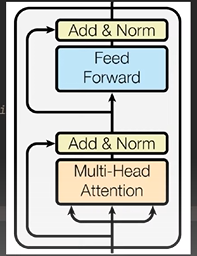

### BatchNorm vs LayerNorm

BatchNorm takes the average across the batch and then normalizes

While LayerNorm takes the average for every single example. So, LayerNorm has more computation

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
         
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out
        

## Encoder
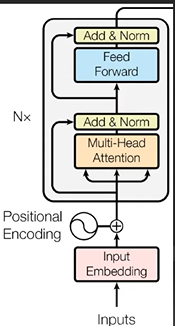

### Positional Encoding
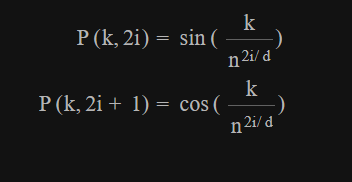
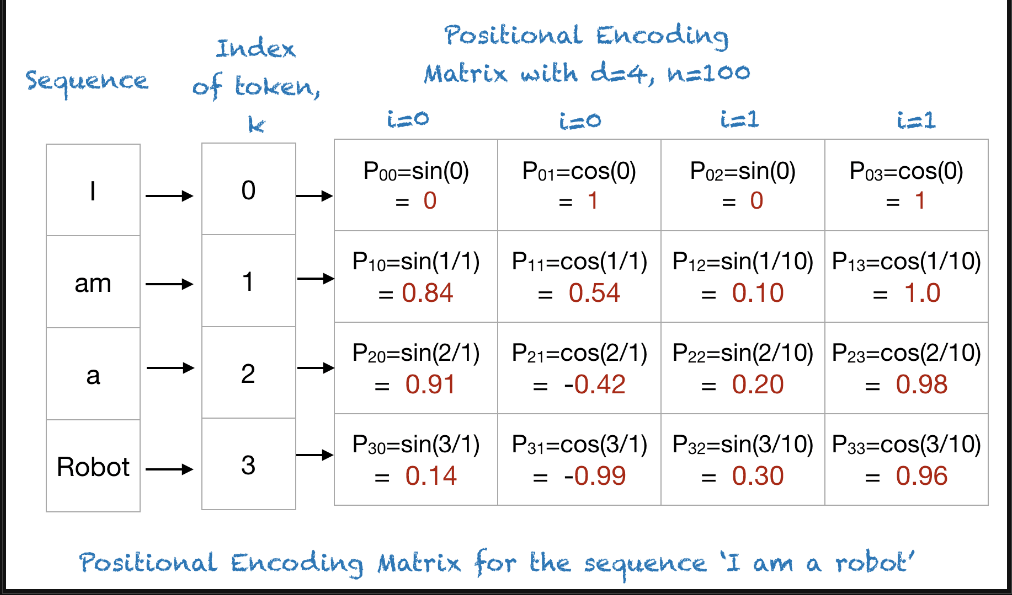

In [10]:
class Encoder(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length #max len of the sentence
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion = forward_expansion,
                )
            for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
#             all of the inputs of the encoder are the same
            out = layer(out, out, out, mask)
    
        return out

## Decoder Block

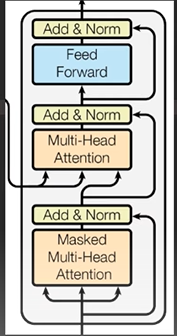

In [23]:
class DecoderBlock(nn.Module):
    def __init__(
        self, embed_size, heads, forward_expansion, dropout, device  
    ):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        
        self.dropout = nn.Dropout(dropout)
        
#         src_mask is needed to avoid the unnecessary computations on the padded input
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

## Decoder
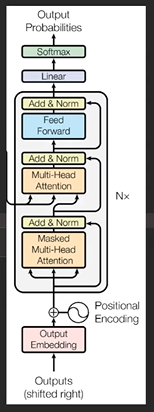

In [27]:
class Decoder(nn.Module):
    def __init__(self,
                 trg_vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 device,
                 max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)]
        )
        
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
            
        out = self.fc_out(x)
        return out

### Putting down things together

In [28]:
# passing the hyperparameters
class Transformer(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            embed_size = 256,
            num_layers = 6,
            forward_expansion = 4,
            heads = 8,
            dropout = 0,
            device = "cuda",
            max_length = 100
    ):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )
        
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout, 
            device,
            max_length
        )
        
        self.src_pad_idx = src_pad_idx 
        self.trg_pad_idx = trg_pad_idx 
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
#         (N, 1, 1, src_len)
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out
         

In [29]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0],[1, 5, 6, 2, 4, 7, 6, 2]]).to(device)
    
    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
    
    out = model(x, trg[:, :-1])
    print(out.shape)

torch.Size([2, 7, 10])


## END of code

-----------------------

In [9]:
import torch
print("Torch version:", torch.__version__)
print("Is CUDA enabled?", torch.cuda.is_available())

Torch version: 2.4.0
Is CUDA enabled? True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_length, embed_size):
    pos = np.arange(max_length)[:, np.newaxis]
    i = np.arange(embed_size)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_size))
    angle_rads = pos * angle_rates
    pos_enc = np.concatenate([np.sin(angle_rads[:, 0::2]), np.cos(angle_rads[:, 1::2])], axis=-1)
    return pos_enc

max_length = 50
embed_size = 16
pos_enc = positional_encoding(max_length, embed_size)

plt.figure(figsize=(10, 8))
plt.pcolormesh(pos_enc, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding')
plt.colorbar()
plt.show()
